We use the tsai package to perform time series regression. This package implements dozens of cutting-edge algorithms for time series classification and regression. Please see [here](https://github.com/timeseriesAI/tsai) for details and package documentation and how to install it.

In [1]:
# !pip install tsai --upgrade

Import the necessary packages.

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

from tsai.data.preparation import SlidingWindowSplitter
from tsai.data.preprocessing import TSStandardize
from tsai.tslearner import TSRegressor
from tsai.callback.core import ShowGraph, EarlyStoppingCallback, SaveModelCallback
from tsai.models.RNN import GRU
import tsai.data.external
import tsai.data.validation
from tsai.metrics import mae, mse
from tsai.inference import load_learner

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

We load the data prepared to model the output sensor 'Out2'. As an example, we will perform regression for it to create a soft sensor modeled from the input sensors.

In [3]:
df_train_Out2 = pd.read_parquet('./data_prepared/train/Out2.parquet')
df_train_Out2

,IN1,IN2,IN3,IN4,IN5,Out2
1970-01-01 00:00:00+00:00,0.077744,0.795565,-0.068312,0.879321,0.134419,0.123661
1970-01-01 00:01:00+00:00,0.080313,0.824595,-0.068312,0.875636,0.134941,0.123661
1970-01-01 00:02:00+00:00,0.087355,0.776258,-0.068312,0.884105,0.132452,0.123661
1970-01-01 00:03:00+00:00,0.091774,0.739149,-0.068312,0.892043,0.131287,0.251010
1970-01-01 00:04:00+00:00,0.091166,0.761332,-0.068312,0.892752,0.136788,0.251010
...,...,...,...,...,...,...
1970-01-10 07:55:00+00:00,-2.225415,-0.899663,-2.259944,-0.942947,-1.039779,-2.550659
1970-01-10 07:56:00+00:00,-2.230137,-0.814217,-2.222946,-0.924413,-1.021914,-2.423311
1970-01-10 07:57:00+00:00,-2.227956,-0.894048,-2.199024,-0.896666,-0.979397,-2.295962
1970-01-10 07:58:00+00:00,-2.222570,-0.730551,-2.227159,-0.880720,-0.926202,-2.168613


Slice the training data into chunks. Here 'get_x' and 'get_y' are indices to be used to select sensors in the 'tags' list, meaning we are using the selected features (according to our feature selection) to model the target sensor 'Out2'. A window length of 9 and a horizon of 0 mean we use 9 timesteps to predict the target at the last timestep in this window. The stride of 1 means we advance the window in 1 time step to create a new data chunk.

In [4]:
df_train = df_train_Out2.copy()
target = 'Out2'

tag_X = [s for s in df_train.columns if s != target and s != 'Time']
tag_y = target
tags = tag_X + [tag_y]

window_length = 9
stride = 1
horizon = 0
Xt_train, yt_train = SlidingWindowSplitter(window_length, stride=stride, horizon=horizon, get_x=list(range(len(tag_X))), get_y=len(tag_X))(df_train[tags])
print(Xt_train.shape, yt_train.shape)

(13432, 5, 9) (13432,)


The 'check_data' function allows us to inspect the data chunks to be used for model training.

In [5]:
tsai.data.external.check_data(Xt_train, yt_train)

X      - shape: [13432 samples x 5 features x 9 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (13432,)  type: ndarray  dtype:float64  isnan: 0


Generate lists of indices to get training and validation data from the training data defined before. Here we sample 10% of the training data to be used as validation during model training.

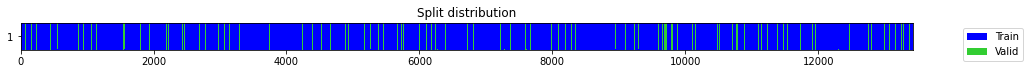

((#12089) [11484,299,12271,6435,4532,2735,12765,4578,11603,10712...],
 (#1343) [5856,7720,8157,6248,4743,7085,8368,1205,1237,11991...])

In [6]:
splits = tsai.data.validation.get_splits(yt_train, valid_size=0.1, stratify=False, random_state=123, shuffle=True)
splits

Here we define several objects and parameters to be used to train the model. Many of these follows the fast.ai framework, as TSAI is built on top of it. The 'batch_tfms' object specifies the pipeline to be executed when getting batches from the training data (just standardize the data in our case). We also define the model architecture and corresponding parameters in the 'arch' and 'arch_config' objects (we use an RNN with GRU units in this example). The 'bs' is the batch size for training. The 'metrics' list defines the metrics to keep track of during training. The 'cbs' list defines the callback functions to be used during training. The 'learner' object defines the fast.ai 'Learner' class to be used. where we use 'TSRegressor' (an implementation from TSAI), which by default uses MSE as the loss function and Adam as the optimizer.

In [7]:
%%capture --no-display

batch_tfms = [TSStandardize(by_var=False, verbose=False)]

arch = GRU
arch_config = {'hidden_size':128, 'n_layers':1, 'bias':True, 'rnn_dropout':0.2, 'bidirectional':True, 'fc_dropout':0.1}

bs = 512
metrics=[mse, mae]
cbs = [ShowGraph(), EarlyStoppingCallback(min_delta=0.001, patience=15), SaveModelCallback(min_delta=0.001)]

learner = TSRegressor(Xt_train, yt_train, splits=splits, batch_tfms=batch_tfms, arch=arch, arch_config=arch_config, bs=bs, metrics=metrics, cbs=cbs)

We use the 'lr_find' method from fast.ai, which tries to find the optimum maximum learning rate to be used in the schedule during training.

SuggestedLRs(valley=0.0018620871705934405)

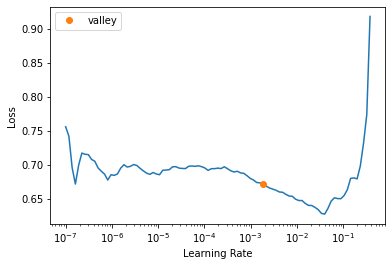

In [8]:
lr_max = learner.lr_find(start_lr=1e-07, end_lr=1)
lr_max

We train the model for a maximum of 500 epochs. We have an early stop defined as a callback function that terminates the training earlier, in case we don’t see any improvement past the specified threshold.

epoch,train_loss,valid_loss,mse,mae,time
0,0.672560,0.687318,0.687318,0.618171,00:00
1,0.652106,0.658446,0.658446,0.603456,00:00
2,0.634385,0.640777,0.640777,0.594651,00:00
3,0.618955,0.629184,0.629184,0.589579,00:00
4,0.608337,0.620591,0.620591,0.585602,00:00
5,0.600266,0.613524,0.613524,0.582955,00:00
6,0.591940,0.607869,0.607869,0.580747,00:00
7,0.585488,0.602705,0.602705,0.578745,00:00
8,0.579412,0.597539,0.597539,0.576519,00:00
9,0.573471,0.591823,0.591823,0.574276,00:00


Better model found at epoch 0 with valid_loss value: 0.6873178482055664.


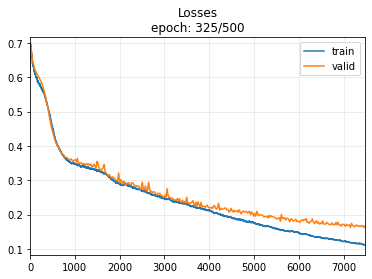

Better model found at epoch 1 with valid_loss value: 0.6584457159042358.
Better model found at epoch 2 with valid_loss value: 0.6407768130302429.
Better model found at epoch 3 with valid_loss value: 0.6291839480400085.
Better model found at epoch 4 with valid_loss value: 0.6205906867980957.
Better model found at epoch 5 with valid_loss value: 0.6135238409042358.
Better model found at epoch 6 with valid_loss value: 0.6078689098358154.
Better model found at epoch 7 with valid_loss value: 0.6027053594589233.
Better model found at epoch 8 with valid_loss value: 0.597539484500885.
Better model found at epoch 9 with valid_loss value: 0.5918229818344116.
Better model found at epoch 10 with valid_loss value: 0.585233211517334.
Better model found at epoch 11 with valid_loss value: 0.5773902535438538.
Better model found at epoch 12 with valid_loss value: 0.5678306221961975.
Better model found at epoch 13 with valid_loss value: 0.5565608143806458.
Better model found at epoch 14 with valid_loss va

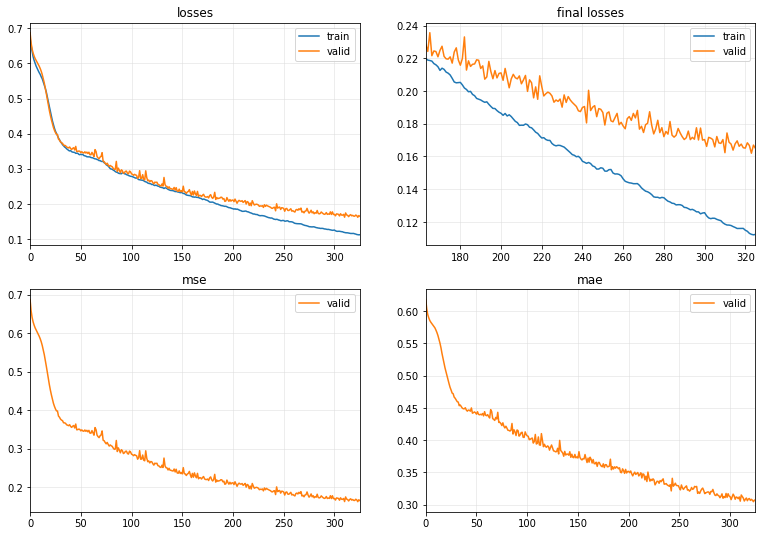

In [9]:
learner.fit_one_cycle(n_epoch=500, lr_max=lr_max)

Print the best validation loss and mean absolute error.

In [10]:
%%capture --no-display

valid_mse = learner.validate()[1]
valid_mae = learner.validate()[2]

In [11]:
print(valid_mse, valid_mae)

0.16229262948036194 0.3052479922771454


Save the learner object to be used later for model inferencing.

In [12]:
learner.export('./models/learner.pkl')